<a href="https://colab.research.google.com/github/Pratham2012/Python-for-Finance/blob/main/Python_for_Finance_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
#Here RELIANCE is our large cap stable asset and SUZLON is our small cap risky asset
stocks = ['RELIANCE.NS','SUZLON.NS']
prices = pd.DataFrame([])
#Date range
start = '2018-01-01'
end = '2022-11-27'
for i in stocks:
  prices[i] = yf.download(i,start=start,end=end)['Adj Close']
prices

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,RELIANCE.NS,SUZLON.NS
Date,,
2018-01-01,881.918274,15.80
2018-01-02,883.275330,15.85
2018-01-03,886.813660,15.75
2018-01-04,892.145447,15.80
2018-01-05,895.005188,15.55
...,...,...
2022-11-21,2550.899902,8.05
2022-11-22,2565.050049,8.00
2022-11-23,2557.050049,7.90


In [ ]:
#Let's calculate value at risk for our portfolio for this time period (Q1) with confidence level of 99%
def portfolio_var(r,level=5):
    return round(-np.percentile(r,level,axis=0)*100,2)

In [ ]:
'''Rember that Var at a certain confidence gives the worst return from the remaining
   samples after eliminating the lowest % values below the confidence internal
   In our case for 99% confidence, the output is the worst return in 99% of the times.
'''
stock_returns = prices.pct_change().dropna()
floor_value = stock_returns.aggregate(portfolio_var)

safe_returns = stock_returns[['RELIANCE.NS']]
risky_returns = stock_returns[['SUZLON.NS']]

In [ ]:
#Create a risky and safe allocation of same size as their respective returns using reindex_like() function
risky_alloc = pd.DataFrame().reindex_like(risky_returns)
safe_alloc = pd.DataFrame().reindex_like(safe_returns)
account_history = pd.DataFrame().reindex_like(safe_returns)

In [ ]:
#Use Var to define floor of your portfolio
#Absolute worst case considering a drop across all your portfolio stocks in the given time period

print("Worst case drop across portfolio is:", round(floor_value.sum(),2),"% at 95% confidence")

Worst case drop across portfolio is: 7.82 % at 95% confidence


In [ ]:
#We can either take this as the floor for our portfolio or define our floor as a certain value above this.
#Let's treat our floor as 20%, i.e. F = 20%

#CPPI basic values definition
investment = 100000
my_floor = investment*0.8
my_M = 5.62

In [ ]:
#Traditional CPPI
dates = risky_returns.index
date_index = len(dates) #Calculating the length of date index so you can it

In [ ]:
for step in range(date_index):
  cushion = (investment - my_floor)/investment #Calculating cushion
  risky_w = my_M*cushion #Calculating the weight of the risky asset
  risky_w = np.minimum(risky_w,1) #Defining the weight such that it is less than 1 (100%)
  risky_w = np.maximum(risky_w,0) #Defining the weight such that it is at least 0 (weight should not go negative)
  safe_w = 1 - risky_w #Defining the weight of the stable asset
  risky_alloc.iloc[step] = (investment*risky_w)*(1+risky_returns.iloc[step]) #Allocation to the risky asset
  safe_alloc.iloc[step] = (investment*safe_w)*(1+safe_returns.iloc[step]) #Allocation to the safe asset
  investment = risky_alloc.iloc[step].sum()+safe_alloc.iloc[step].sum() #CPPI which is your investment to the next iteration
  account_history.iloc[step] = investment

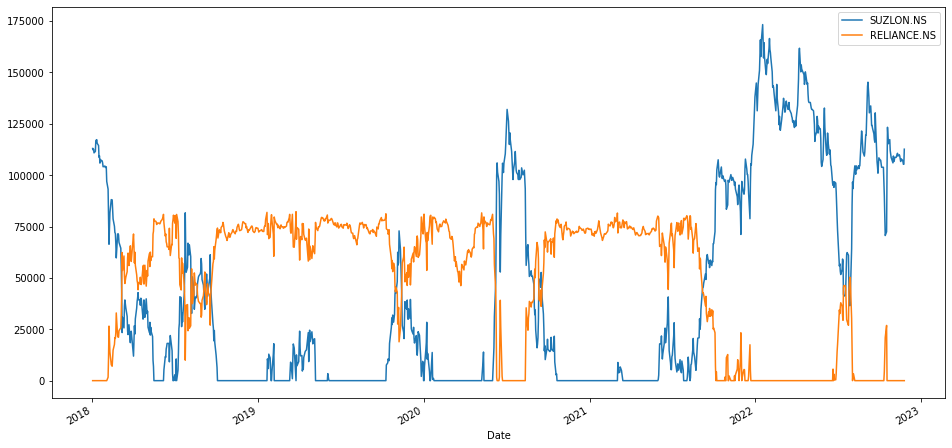

In [ ]:
#Wealth with CPPI
account_history.columns = ['With CPPI']
#Plot the risky and safe allocations
axis1 = risky_alloc.plot(figsize = (16,8))
safe_alloc.plot(ax=axis1)

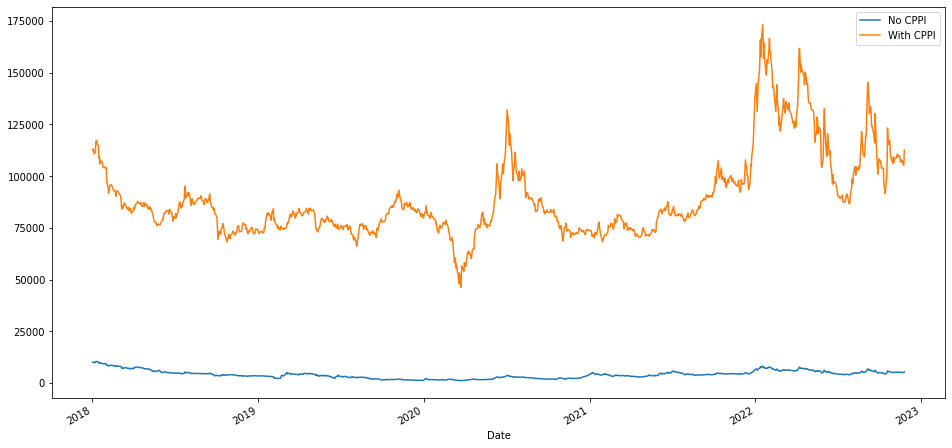

In [ ]:
#Wealth without CPPI
risky_wealth = (10000)*(1+risky_returns).cumprod()
risky_wealth.columns = ['No CPPI']
axis2 = risky_wealth.plot(figsize=(16,8))
account_history.plot(ax=axis2)